In [94]:
# Explanation of prediction output when activation is sigmoid:
# https://forum.freecodecamp.org/t/model-predict-output/470349

import tensorflow as tf
import tensorflow_datasets as tfds
import logging, os
import pandas as pd
import time
from tensorflow.keras.models import load_model
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"cats_vs_dogs/"
os.system("mkdir -p " + OUTPUT_PATH)

0

In [95]:
import tensorflow_datasets as tfds

DATA_PATH = "../../../../../local_data/datasets/animals/"
# Initialize the ImageFolder dataset
builder = tfds.ImageFolder(DATA_PATH)

# Print dataset information
metadata=builder.info
print(builder.info)  # This will show the number of examples, labels, etc.

# Create the dataset
# test_dataset = builder.as_dataset(
#     split='test',
#     shuffle_files=True
# )
(train_dataset, test_dataset)= builder.as_dataset(
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True
)
print(f"Number of test samples: {test_dataset.cardinality()}")

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='../../../../../local_data/datasets/animals/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'cats_vs_dogs': <SplitInfo num_examples=unknown, num_shards=1>,
        'downloads': <SplitInfo num_examples=unknown, num_shards=1>,
        'test': <SplitInfo num_examples=7, num_shards=1>,
        'train': <SplitInfo num_examples=7, num_shards=1>,
    },
    citation="""""",
)
Number of test samples: 7


In [96]:
print("test_dataset=",test_dataset)

test_dataset= <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [97]:
for images, labels in test_dataset.take(5):
    print(labels)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [98]:
# for images in test_dataset.take(2):
#     print(images)

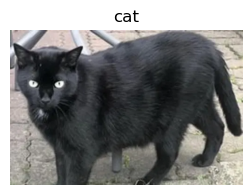

In [99]:
plt.figure(figsize=(3, 3))
for images, labels in test_dataset.take(1):
    plt.imshow(images)
    plt.title(metadata.features['label'].int2str(labels))
    plt.axis("off")

,image,label
0,,1 (cat)
1,,2 (dog)

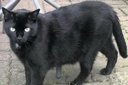
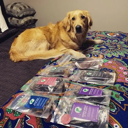

In [100]:
tfds.as_dataframe(test_dataset.take(2), metadata)


In [101]:
# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    return image, label

# train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

batch_size = 64
# train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)

In [102]:
# Load model
filename = "valacc_0.641_epochs_10_date_20250719-150250.h5"

fullpath = f"{OUTPUT_PATH}{filename}"
model = load_model(fullpath)
model.summary()


# Make predictions
predictions = model.predict(test_dataset)
allpreds=predictions.flatten()
allpnorms = np.where(allpreds > 0.5, 1, 0)+1

alllabels=np.empty(0)
for images, labels in test_dataset:
    alllabels = np.append(alllabels, labels.numpy().flatten())

score = metrics.accuracy_score(alllabels, allpnorms)
print("Validation accuracy score: {}".format(score))

collabels = pd.DataFrame(alllabels, columns=["l"])
colpreds = pd.DataFrame( allpreds, columns=["pred"])
pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
diff = collabels["l"] - pnorm["pnorm"]

compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
compare.columns = ["l", "pred", "pnorm","diff"]
print(compare)

compare.to_csv(OUTPUT_PATH + "pred_test_load.csv", index=False)    

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 246016)            0         
                                                                 
 dense_10 (Dense)            (None, 512)              

,image,label,predictions,pred norm,correct
0,,1 (cat),0.000467,1,True
1,,2 (dog),0.734142,2,True
2,,1 (cat),0.017727,1,True
3,,1 (cat),0.370871,1,True
4,,1 (cat),0.256680,1,True
5,,2 (dog),0.004738,1,False
6,,2 (dog),0.898228,2,True

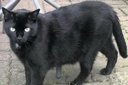
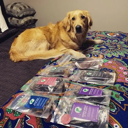
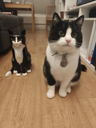
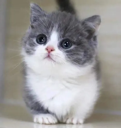
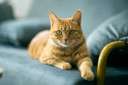
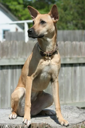
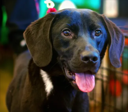

In [104]:
# # Reload the dataset (need without pre-processing)
(train_dataset, test_dataset)= builder.as_dataset(
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True
)

number_of_images=7
allcorrect = (allpnorms == alllabels)

new_df=tfds.as_dataframe(test_dataset.take(number_of_images), metadata)
new_df['predictions'] = allpreds[0:number_of_images]
new_df['pred norm'] = allpnorms[0:number_of_images]
new_df['correct'] = allcorrect[0:number_of_images]
new_df